In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import do_pca_pt, spearman_rho_pools, spearman_rho_grid, do_denoised_pca, calc_rhos
from jtb_2022_code import FigureSingleCellData

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import spearmanr

In [3]:
## LOAD AND PROCESS UMAP FOR PCA AND PT PANELS ###
data = FigureSingleCellData()
data.do_projections()
data.apply_inplace_to_everything(do_pca_pt)
data.apply_inplace_to_expts(do_denoised_pca, max(N_PCS))
data.apply_inplace_to_expts(do_pca_pt, pca_key="denoised_pca", pt_key="denoised_pca_pt")
data.load_pseudotime()
#data.save()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad


In [59]:
N_NEIGHBORS.tolist()


[15, 25, 35, 45, 55, 65, 75, 85, 95, 105]

In [53]:
data.apply_to_expts(lambda x: x.uns['denoised']['params']['n_pcs'])

[85, 45, 105, 45]

In [55]:
data.apply_to_expts(lambda x: int(x.obs['denoised_n'].median()))

[75, 75, 85, 75]

In [56]:
data.expts

[(1, 'WT'), (1, 'fpr1'), (2, 'WT'), (2, 'fpr1')]

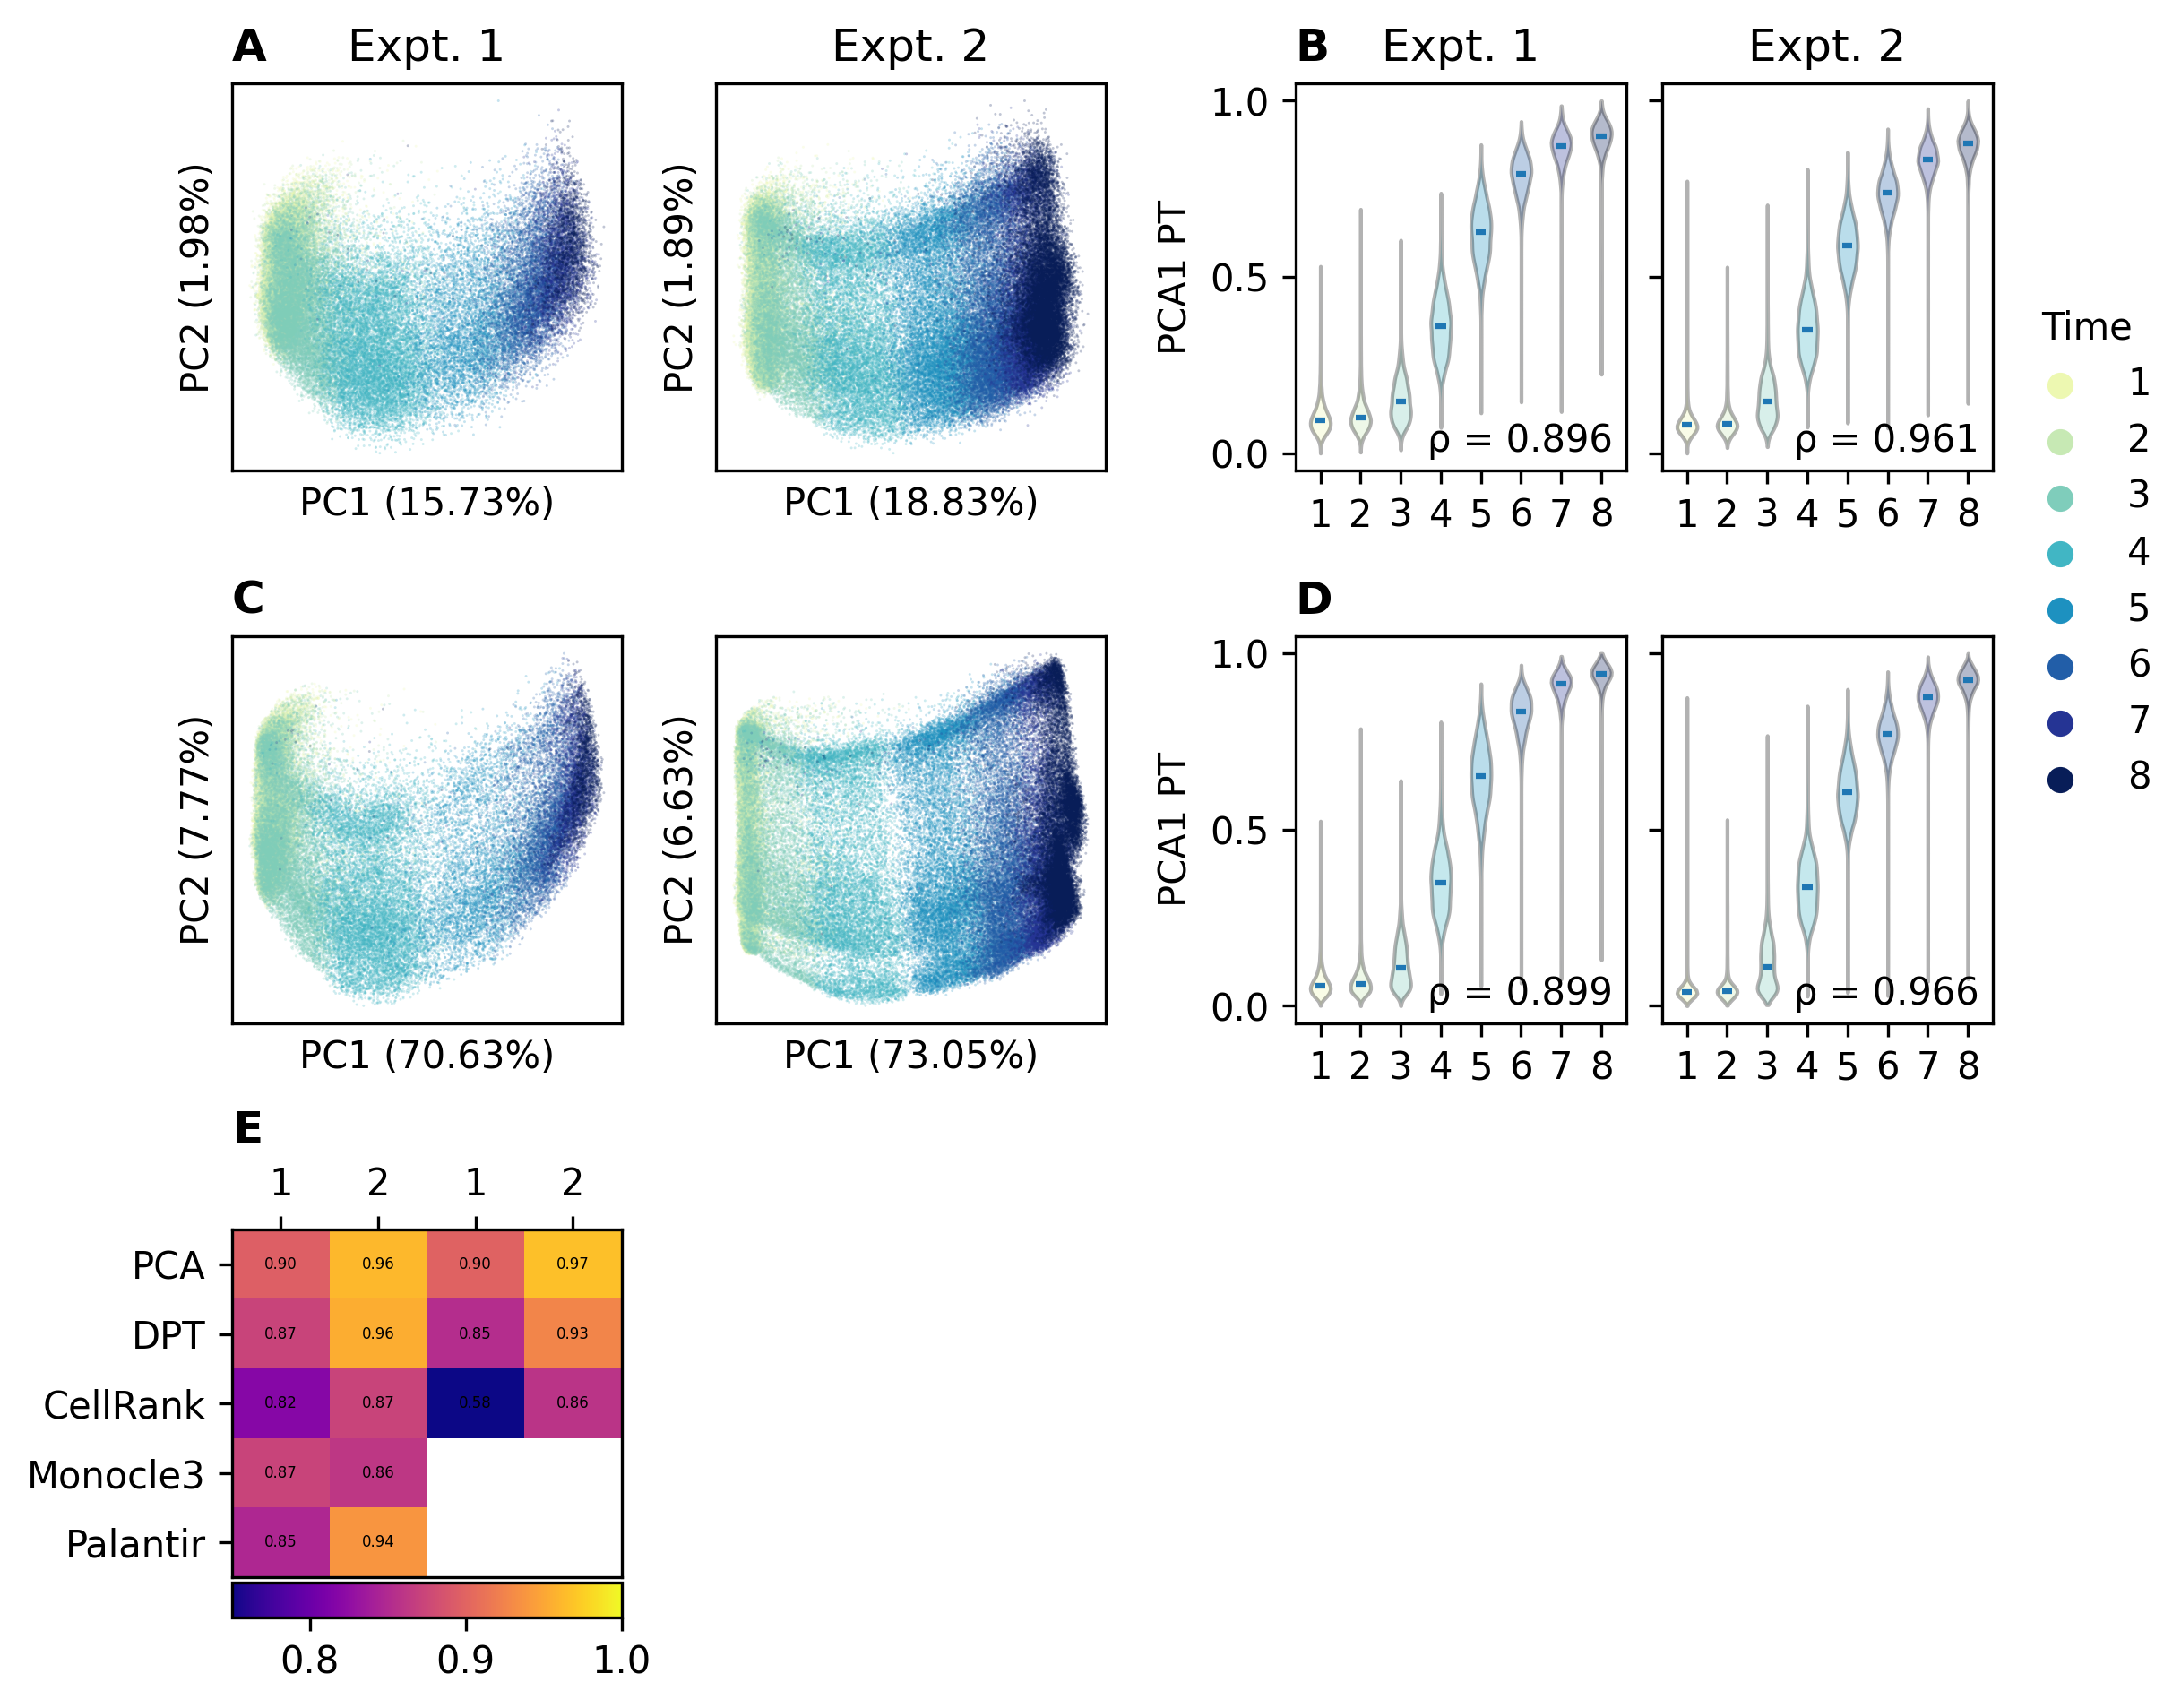

In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


panel_labels = {'pca_1': "A",
                'pca_pt_1': "B",
                'pca_d1': "C",
                'pca_pt_d1': "D",
                'method_hm': "E"}

panel_titles = {'pca_1': "Expt. 1",
                'pca_2': "Expt. 2",
                'pca_pt_1': "Expt. 1",
                'pca_pt_2': "Expt. 2",
                'pca_d1': "",
                'pca_d2': "",
                'pca_pt_d1': "",
                'pca_pt_d2': "",}

layout = [['pca_1', '.', 'pca_2', '.', 'pca_pt_1', 'pca_pt_2', 'pca_lgd'],
          ['pca_d1', '.', 'pca_d2', '.', 'pca_pt_d1', 'pca_pt_d2', 'pca_lgd'],
          ['method_hm', '.', '.', '.', '.', '.', '.']]

hm_labels = {'pca': 'PCA', 'dpt': 'DPT', 
             'cellrank': 'CellRank', 
             'monocle': 'Monocle3', 
             'palantir': 'Palantir'}

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.05, 1, 0.075, 0.85, 0.85, 0.15], 
                                               height_ratios=[1, 1, 1],
                                               wspace=0.01, hspace=0.025), 
                              figsize=(8, 6), dpi=300,
                              constrained_layout=True)

axd["pca_lgd"].axis('off')


def _make_method_heatmap_data(pdata):
    raw = pdata.all_data.uns['rho'].loc[(slice(None), "WT"), :].T
    raw.columns = pd.MultiIndex.from_tuples([(1, "raw"), (2, "raw")])
    
    denoised = pdata.all_data.uns['denoised_rho'].loc[(slice(None), "WT"), :].T.reindex(raw.index)
    denoised.columns = pd.MultiIndex.from_tuples([(1, "denoised"), (2, "denoised")])
    
    return pd.concat((raw, denoised), axis=1)


def _plt_pt_violins(pdata, ax, pt_key, include_labels=True):
    pca_pt_data = {k: v[pt_key] for k, v in pdata.obs[[pt_key, 'Pool']].groupby("Pool")}
    ref = ax.violinplot([pca_pt_data[j] for j in range(1,9)], showmeans=False, showmedians=True, showextrema=False)
    ax.set_xticks(np.arange(8) + 1, labels=np.arange(8) + 1)
    ax.set_yticks([0.0, 0.5, 1.0], labels=[0.0, 0.5, 1.0] if include_labels else ['', '', ''])
    
    if include_labels:
        ax.set_ylabel("PCA1 PT")
    
    rho = spearman_rho_pools(pdata.obs['Pool'], pdata.obs[pt_key])
    ax.annotate("ρ = " + f"{rho:.3f}", xy=(5, 0.2),  xycoords='data', xytext=(0.4, 0.05), textcoords='axes fraction')
    
    for part, c in zip(ref['bodies'], pool_palette()):
        part.set_facecolor(c)
        part.set_edgecolor('black')
        
    return ref


for i in range(1,3):
    pca_key = "pca_" + str(i)
    pca_d_key = "pca_d" + str(i)
    
    pt_key = "pca_pt_" + str(i)
    pt_d_key = "pca_pt_d" + str(i)
    
    pca_data = data.expt_data[i, "WT"]
    pca_d_data = get_clean_anndata(pca_data)
    pca_d_data.obsm['X_pca'] = pca_data.obsm['denoised_pca'].copy()
    pca_d_data.uns['pca'] = pca_data.uns['denoised_pca'].copy()
    

    ### PANEL A ###
    fig_refs[pca_key] = sc.pl.pca(pca_data, ax=axd[pca_key], 
                                  color="Pool", palette=pool_palette(), 
                                  show=False, alpha=0.25, size=2, legend_loc='none',
                                  annotate_var_explained=True)
    fig_refs[pca_d_key] = sc.pl.pca(pca_d_data, ax=axd[pca_d_key], 
                                    color="Pool", palette=pool_palette(), 
                                    show=False, alpha=0.25, size=2, legend_loc='none',
                                    annotate_var_explained=True)

    ### PANEL B ###
    fig_refs[pt_key] = _plt_pt_violins(pca_data, axd[pt_key], 'pca_pt', include_labels= i == 1)
    fig_refs[pt_d_key] = _plt_pt_violins(pca_d_data, axd[pt_d_key], 'denoised_pca_pt', include_labels= i == 1)
    
hm_data = _make_method_heatmap_data(data)

fig_refs['method_hm'] = axd['method_hm'].imshow(hm_data, vmin=0.75, vmax=1.0,
                                                cmap='plasma', aspect='auto', interpolation='nearest')

axd['method_hm'].set_yticks(range(hm_data.shape[0]), labels=hm_data.index.map(lambda x: hm_labels[x]))
axd['method_hm'].set_xticks(range(hm_data.shape[1]), labels=[1, 2, 1, 2])
axd['method_hm'].xaxis.tick_top()

divider = make_axes_locatable(axd['method_hm'])
axd['method_hm_cbar'] = divider.append_axes('bottom', size='10%', pad=0.02)
axd['method_hm_cbar'].set_xlabel("Spearman ρ")
fig.colorbar(fig_refs['method_hm'], cax=axd['method_hm_cbar'], orientation="horizontal", aspect=80)

# https://stackoverflow.com/questions/11917547/how-to-annotate-heatmap-with-text-in-matplotlib
for y in range(hm_data.shape[0]):
    for x in range(hm_data.shape[1]):
        n = hm_data.iloc[y, x]
        if np.isnan(n):
            continue
        axd['method_hm'].text(x, y, '%.2f' % n, 
                              horizontalalignment='center', 
                              verticalalignment='center', 
                              size=4)

fig_refs['pca_legend'] = add_legend(axd['pca_lgd'], 
                                    pool_palette(), 
                                    data.all_data.obs['Pool'].dtype.categories.values,
                                    title = "Time")

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(label, loc='left', weight='bold')
    
for ax_id, label in panel_titles.items():
    axd[ax_id].set_title(label)

fig.savefig(FIGURE_2_FILE_NAME + ".png", facecolor="white") 